# Cancer Classification for Genomic Data
The main file for testing of classification models.

## Import Libraries

In [19]:
# import preprocessors
from data.preprocess_data import preprocess_data
# import third party various libraries
import numpy as np
import pandas as pd
from typing import Literal # dan and his typing
from collections import defaultdict
# small army of sklearn imports
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import RFECV, VarianceThreshold, SelectKBest, f_classif
# import specific models 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
# stop warning me
import warnings
warnings.filterwarnings("ignore")

ImportError: cannot import name 'preprocess_data' from 'data.preprocess_data' (/Users/hannazelis/Northwestern/fall2024/MSAI339DS/finalProject/github/DSProject/data/preprocess_data.py)

In [16]:
# Define dictionary for scores
models = defaultdict(dict[Literal['val_accuracy', 'test_accuracy'], float]) 

NameError: name 'defaultdict' is not defined

In [15]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data()

NameError: name 'preprocess_data' is not defined

The `fit_and_val_classifier` function is a general function for testing an `sklearn` classifier on the preprocessed dataset. 

In [14]:
from time import time

def fit_and_val_sklearn_classifier(classifier, X_train=X_train, X_val=X_val, verbose=False):
    start = time()
    classifier.fit(X_train, y_train)
    if verbose: print(f'Classifier fit in {(time()-start):.3f}s')
    y_pred_val = classifier.predict(X_val)
    val_acc = accuracy_score(y_true=y_val, y_pred=y_pred_val)
    if verbose: 
        print(f'Validation accuracy: {(val_acc*100):.3f}%\nClassification Report (Validation):\n{classification_report(y_val, y_pred_val)}')
    return val_acc

NameError: name 'X_train' is not defined

## Summary Table of Results
*Note that the below cell may take a while to run, as it fits a large number of models*

We next generate a summary of how different models, hyperparameters, and preprocessing methods affect the validation accuracy. We use this table to decide that the best combination for modeling is TODO. In general, we see high performance accross many types of tree-based and linear models. 

The rest of the file shows specifics for different models and  data-preprocessing methods. 

In [ ]:
# TODO reformat everything to this format

def make_val_summary_table(models_lst, preprocessed_data_lst):
    df_dict = {'Models':[]}
    for data_source in preprocessed_data_lst:
        # ds_name = data_source.name
        ds_name = 'Raw Data'
        df_dict[ds_name] = []
        data_source = preprocess_data()
        for model in models_lst:
            df_dict['Models'].append(str(model))
            val_acc = fit_and_val_sklearn_classifier(
                classifier=model,
                X_train=data_source[0],
                X_val=data_source[2],
            )
            df_dict[ds_name].append(val_acc*100)
    df = pd.DataFrame(df_dict)
    return df

rand_state = 42 # 
summary_table = make_val_summary_table(
    models_lst = [
        DecisionTreeClassifier(random_state=rand_state),
        RandomForestClassifier(random_state=rand_state),
        AdaBoostClassifier(n_estimators=10, random_state=rand_state),
        GradientBoostingClassifier(n_estimators=5, random_state=rand_state),
        LogisticRegression(random_state=rand_state)
    ],
    preprocessed_data_lst = [
        preprocess_data() 
    ]
)

pd.set_option('display.precision', 2) # set the precision of the accuracy
summary_table

,Models,Raw Data
0,DecisionTreeClassifier(random_state=42),96.88
1,RandomForestClassifier(random_state=42),100.00
2,"AdaBoostClassifier(n_estimators=10, random_sta...",80.62
3,"GradientBoostingClassifier(n_estimators=5, ran...",98.75
4,LogisticRegression(),100.00


## Shapley Values - Nicole

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

print('--- Random Forest ---')
val_acc = fit_and_val_sklearn_classifier(classifier=model, verbose=True)

--- Random Forest ---
Classifier fit in 1.285s
Validation accuracy: 100.000%
Classification Report (Validation):
              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00        61
        COAD       1.00      1.00      1.00        19
        KIRC       1.00      1.00      1.00        30
        LUAD       1.00      1.00      1.00        19
        PRAD       1.00      1.00      1.00        31

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160



TODO explain

In [17]:
import shap

def shapley_value_reduce(model, k=1000):
    # Calculate Shapley values
    explainer = shap.TreeExplainer(model)  
    shap_values = explainer.shap_values(X_train)

    # mean absolute Shapley value for each feature 
    shap_values_mean = np.abs(shap_values).mean(axis=0)  

    top_k_features = np.argsort(shap_values_mean)[-k:]  
    selected_features = X_train.columns[top_k_features.flatten()]

    X_train_reduced = X_train[selected_features]
    X_val_reduced = X_val[selected_features] 
    X_test_reduced = X_test[selected_features]

    return X_train_reduced, X_val_reduced, X_test_reduced

# model from previous cell
X_train_reduced, X_val_reduced, X_test_reduced = shapley_value_reduce(model)

model_reduced = RandomForestClassifier(n_estimators=100, random_state=42)

val_acc = fit_and_val_sklearn_classifier(
    classifier = model_reduced,
    X_train = X_train_reduced,
    X_val = X_val_reduced,
    verbose=True
)


Classifier fit in 1.053s
Validation accuracy: 56.250%
Classification Report (Validation):
              precision    recall  f1-score   support

        BRCA       0.64      0.64      0.64        61
        COAD       0.75      0.63      0.69        19
        KIRC       0.75      0.70      0.72        30
        LUAD       0.20      0.16      0.18        19
        PRAD       0.38      0.48      0.42        31

    accuracy                           0.56       160
   macro avg       0.54      0.52      0.53       160
weighted avg       0.57      0.56      0.56       160



TODO explain

## Random Forest w/ ANOVA - Nicole
TODO explain

In [1]:
def filter_by_feature_performance():
    y_train = y_train.values.ravel() if hasattr(y_train, 'values') else y_train.ravel()
    y_val = y_val.values.ravel() if hasattr(y_val, 'values') else y_val.ravel()
    y_test = y_test.values.ravel() if hasattr(y_test, 'values') else y_test.ravel()

    # remove low variance features
    variance_selector = VarianceThreshold(threshold=0.01)
    X_train_var = variance_selector.fit_transform(X_train)
    X_val_var = variance_selector.transform(X_val)
    X_test_var = variance_selector.transform(X_test)

    # use SelectKBest to reduce to top 5000 features based on ANOVA F-statistic
    k_best_selector = SelectKBest(f_classif, k=5000)
    X_train_kbest = k_best_selector.fit_transform(X_train_var, y_train)
    X_val_kbest = k_best_selector.transform(X_val_var)
    X_test_kbest = k_best_selector.transform(X_test_var)

    base_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    base_model.fit(X_train_kbest, y_train)

    # get top 1000 features based on feature importance
    importances = base_model.feature_importances_
    top_indices = np.argsort(importances)[-1000:]

    X_train_final = X_train_kbest[:, top_indices]
    X_val_final = X_val_kbest[:, top_indices]
    X_test_final = X_test_kbest[:, top_indices]
    
    return X_train_final, X_val_final, X_test_final

# train model on reduced dataset
final_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

fit_and_val_sklearn_classifier(
    classifier=final_model,
    X_train = X_train_final,
    X_val = X_val_final,
    verbose=True
)

# test model on test set
y_pred_test = final_model.predict(X_test_final)
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Classification Report (Test):\n", classification_report(y_test, y_pred_test))


NameError: name 'RandomForestClassifier' is not defined

TODO interpretation

## Log Regression - Hanna
TODO explain

In [ ]:
from sklearn.preprocessing import StandardScaler

#initialize logistic regression model, configured for multinomial classificaiton (>2 classes), using 'lbfgs' solver
#the 'max_iter' parameter ensures sufficient iterations for convergence, and 'random_state' ensures reproducibility
#https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)

print(f'--- Logistic Regression ---')
val_acc = fit_and_val_sklearn_classifier(classifier=log_reg, verbose=True)


--- Logistic Regression ---
Classifier fit in 0.817s
Validation accuracy: 100.000%
Classification Report (Validation):
              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00        61
        COAD       1.00      1.00      1.00        19
        KIRC       1.00      1.00      1.00        30
        LUAD       1.00      1.00      1.00        19
        PRAD       1.00      1.00      1.00        31

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160



TODO explain

## K-Means with PCA - Hanna
TODO explain

K-Means Report
Accuracy: 0.92
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.99      0.82      0.90       300
           1       1.00      0.99      0.99       146
           2       1.00      0.95      0.97        78
           3       0.70      0.99      0.82       141
           4       1.00      0.99      0.99       136

    accuracy                           0.92       801
   macro avg       0.94      0.95      0.94       801
weighted avg       0.94      0.92      0.92       801



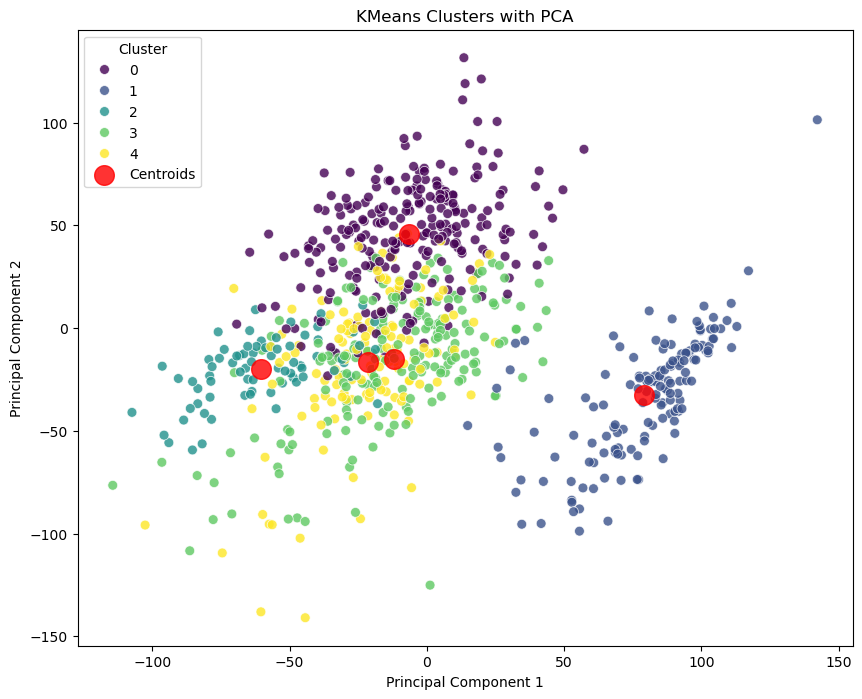

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import mode
from scipy.optimize import linear_sum_assignment

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import contingency_matrix
from sklearn.model_selection import GridSearchCV


#load data; load the feature data and labels from Parquet files into Pandas DataFrames
#the 'data.parquet' file contains the features, while 'labels.parquet' contains the target class labels
#https://pandas.pydata.org/docs/reference/api/pandas.read_parquet.html
data = pd.read_parquet('data.parquet')
labels = pd.read_parquet('labels.parquet')

#map the labels to an encoding dicitonary to ensure consistent class mapping
labels['Class'] = labels['Class'].map(encoding_dict)

#rename columns for readability and usability
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html
data.rename(columns={'Unnamed: 0': 'sample_id'}, inplace=True)
labels.rename(columns={'Unnamed: 0': 'sample_id'}, inplace=True)


#merge datasets; combine the features and labels intoa single DataFrame, joining on the common column 'sample_id'
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html
merged_data = pd.merge(data, labels, on='sample_id')

#drop the sample_id column as it isn't needed for analaysis
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html
#features
data = merged_data.drop(columns=['sample_id', 'Class'])
#labels
labels = merged_data['Class']

#standardize features with StandardScalar to normalize values, ensuring each feature has a mean of 0 and
# a standard deviation of 1
#https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.StandardScaler.html
scaler = StandardScaler()
#fit and transform the training data
data_scaled = scaler.fit_transform(data)





#Grid Search CV: https://www.analyticsvidhya.com/blog/2021/06/tune-hyperparameters-with-gridsearchcv/
def pca_grid_search(data, components_range):
    results = {}
    for n in components_range:
        pca = PCA(n_components=n, random_state=42)
        reduced_data = pca.fit_transform(data)
        variance_explained = sum(pca.explained_variance_ratio_)
        results[n] = variance_explained
    return results

#perform PCA grid search
#components_range = rcomponents_range = range(200, min(data_scaled.shape[1], 801), 50) # Include up to 801 or total features - 2 minutes and 6.4 seconds
max_components = min(500, data_scaled.shape[1]) # Limit to 500 components or feature count
components_range = range(50, max_components, 50) # Start from 50 with a step of 50
variance_results = pca_grid_search(data_scaled, components_range)

#find the optimal number of components (e.g., retain ~95% variance)
optimal_components = max(k for k, v in variance_results.items() if v >= 0.85)





#apply PCA for dimensionality reduction: reduce the feature set to 20 principlal components to simplify the dataset
# while retraining as much variance as possible
#https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
pca = PCA(n_components=optimal_components, random_state=42)
data_reduced = pca.fit_transform(data_scaled)





#apply k-means clustering
#https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.KMeans.html
#define the number of clustesr
clusters = len(np.unique(labels))
#apply kmeans
k_means = KMeans(n_clusters=clusters, random_state=42, init='k-means++')
#fit the scaled down data
k_means.fit(data_reduced)
y_kmeans = k_means.predict(data_reduced)

#get clusters and centroids
cluster_labels = k_means.labels_
centroids = k_means.cluster_centers_





# #compute the contingency matrix
# #https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.cluster.contingency_matrix.html
# cont_matrix = contingency_matrix(labels, cluster_labels)

# #match each cluster to the true label with the highest count
# cluster_label_match = np.argmax(cont_matrix, axis=1)

# #map predicted cluster labels to the corresponding true labels
# mapped_cluster_labels = np.array([cluster_label_match[label] for label in cluster_labels])



#compute the contingency matrix
cont_matrix = contingency_matrix(labels, cluster_labels)

#solve the optimal alignment problem
row_ind, col_ind = linear_sum_assignment(-cont_matrix) # Negative for maximization

#map cluster labels to ground truth labels
mapped_cluster_labels = np.zeros_like(cluster_labels)
for i, j in zip(row_ind, col_ind):
    mapped_cluster_labels[cluster_labels == j] = i





#accuracy and classificaition report
accuracy= accuracy_score(labels, mapped_cluster_labels)
classification_r = classification_report(labels, mapped_cluster_labels)

print("K-Means Report")
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report (Test):\n", classification_r)

#silhouette score with euclidean metric
# silhouette_s = silhouette_score(X=data_scaled, labels=cluster_labels, metric='euclidean')
# print(f"Silhouette Score: {silhouette_s:.2f}")

#2d visualization using PCA (reduce to 2 dimensions for plotting)
plt.figure(figsize=(10, 8))
sns.scatterplot(
x=data_reduced[:, 0], y=data_reduced[:, 1], hue=mapped_cluster_labels, palette='viridis', s=50, alpha=0.8)
plt.scatter(k_means.cluster_centers_[:, 0], k_means.cluster_centers_[:, 1], c='red', s=200, alpha=0.8, label="Centroids")
plt.title("KMeans Clusters with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", loc="best")
plt.show()


## Decision Trees, AdaBoost & Gradient Boosting - Jack & Dan
We next test the boosting algorithms Gradient Boosting and AdaBoost. We conduct a small hyperparameter search over the number of estimators `n_estimators` trained by these ensemble methods.

In [ ]:
dtree = DecisionTreeClassifier()

adaboost = AdaBoostClassifier(n_estimators=10)

gradboost = GradientBoostingClassifier(n_estimators=5)

rforest = RandomForestClassifier(n_estimators=100, random_state=42)

print('--- Decision Tree ---')
val_acc = fit_and_val_sklearn_classifier(classifier=dtree, verbose=True)

print('--- AdaBoost ---')
val_acc = fit_and_val_sklearn_classifier(classifier=adaboost, verbose=True)

print('--- Gradient Boosting ---')
val_acc = fit_and_val_sklearn_classifier(classifier=gradboost, verbose=True)




--- Decision Tree ---
--- AdaBoost ---
--- Gradient Boosting ---


KeyboardInterrupt: 

In terms of performance, both the Gradient Boosting and AdaBoost classifiers achieve >99% validation accuracy and >94% test accuracy on the dataset, though there are some differences in the models. Gradient Boosting achieves this performance reliably, but training is an order of magnitude slower. In contrast, AdaBoost is less reliable, but trains significantly faster even with a larger number of estimators. 

## SVM - Hanna

In [13]:
from sklearn.svm import SVC

#initalize the SVM model
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

print("Support Vector Machine")
#evaluate the svm model
val_acc = fit_and_val_sklearn_classifier(classifier=svm_model, verbose=True)

#test the model on the test set
svm_model.fit(X_train, y_train)
y_pred_test = svm_model.predict(X_test)
print("Test Accuracy: ", accuracy_score(y_test, y_pred_test))
print("Classification Report (Test): \n", classification_report(y_test, y_pred_test))

Support Vector Machine


NameError: name 'fit_and_val_sklearn_classifier' is not defined